In [20]:
from dotenv import load_dotenv
import os
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing_extensions import TypedDict

load_dotenv()
from langchain_groq import  ChatGroq
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

llm=ChatGroq(model="qwen-2.5-32b")
result=llm.invoke("Hello")
result

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 30, 'total_tokens': 40, 'completion_time': 0.05, 'prompt_time': 0.003670319, 'queue_time': 0.233998177, 'total_time': 0.053670319}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-e7a6c76a-4bd6-4b98-b72b-7702d1fa8f62-0', usage_metadata={'input_tokens': 30, 'output_tokens': 10, 'total_tokens': 40})

In [21]:
# Graph state
class State(TypedDict):
    description: str
    coder: str
    peer_reviewer: str
    check_score: str
    Summary: str

In [22]:
def developer(state: State):
    """First LLM call to generate initial code"""

    if 'per_reviewer' in state and state['peer_reviewer'] :
        msg = llm.invoke(f"Rewrite the Python code based on the original requirements: {state['description']} and addressing the feedback from: {state['peer_reviewer']} ")
    else:
        msg = llm.invoke(f"Write a python code based on the {state['description']}")
    return {"coder": msg.content}

In [23]:
def code_reviewer(state: State):
    """LLM call to review the code"""

    msg = llm.invoke(f"Review the code for correctness and performance:\n{state['coder']}\n"
    f"Provide brief, specific feedback. End with PASS or FAIL classification.")
    
    return {"peer_reviewer": msg.content}


In [24]:
def check_review(state:State):
    "Extract PASS/FAIL decision from reviewer"

    if "PASS" in state['peer_reviewer']:
        return "PASS"
    return 'FAIL'

In [25]:
def summary_gen(state: State):
    "Based on review decision it should generate the report"
    s1 = llm.invoke(f"Based on provided review {state['peer_reviewer']} create a summary report in markdown format")
    
    return {'summary':s1.content}

In [26]:
test_flow = StateGraph(State)
#add node
test_flow.add_node("developer",developer)
test_flow.add_node("code_reviewer", code_reviewer)
test_flow.add_node("summary_gen",summary_gen)

#add edge
test_flow.add_edge(START,"developer")
test_flow.add_edge("developer","code_reviewer")
test_flow.add_conditional_edges(
    "code_reviewer",
    check_review,
    {"PASS":"summary_gen","FAIL":"developer"}
)
test_flow.add_edge("summary_gen",END)

graph = test_flow.compile()

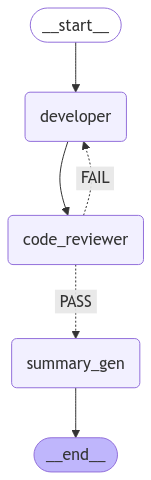

In [27]:
from IPython.display import display,Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [28]:
res = graph.invoke({"description":"generate a code to check if a string is palindrome "},{'recursion_limit':100})
res

{'description': 'generate a code to check if a string is palindrome ',
 'coder': 'Certainly! Below is a simple Python code snippet that checks if a given string is a palindrome. A palindrome is a word, phrase, or sequence that reads the same backward as forward, ignoring spaces, punctuation, and capitalization.\n\n```python\ndef is_palindrome(s):\n    # Normalize the string by removing non-alphanumeric characters and converting to lower case\n    s = \'\'.join(c.lower() for c in s if c.isalnum())\n    \n    # Check if the string is equal to its reverse\n    return s == s[::-1]\n\n# Example usage\ntest_strings = ["Madam, I\'m Adam", "A Toyota! Race fast, safe car!", "Not a palindrome"]\nfor test in test_strings:\n    print(f"\'{test}\' -> {is_palindrome(test)}")\n```\n\nThis code defines a function `is_palindrome` which takes a string `s` as input. The function first cleans the string by removing any non-alphanumeric characters and converting it to lowercase. Then, it checks if the clea